In [1]:
!pip install datasets

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: C:\Users\venka\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
from datasets import load_dataset
import pandas as pd

# Load datasets
webtext = load_dataset("wikitext", 'wikitext-2-raw-v1', split="train")  # Human-written
gpt2_output = load_dataset("cc_news", split="train")  # AI-generated dataset replacement
# Use 'squad' as an alternative for adversarial modifications
adversarial_qa = load_dataset("squad", split="train")  # Adversarial modifications

# Convert to DataFrame
human_texts = pd.DataFrame({"text": webtext["text"], "label": 0})  # Human = 0
ai_texts = pd.DataFrame({"text": gpt2_output["text"], "label": 1})  # AI = 1
adv_texts = pd.DataFrame({"text": adversarial_qa["context"], "label": 2})  # Adversarial = 2

# Merge datasets
data = pd.concat([human_texts, ai_texts, adv_texts]).dropna().sample(frac=1).reset_index(drop=True)

print(data.head())

C:\Users\venka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\venka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\venka\.cache\huggingface\hub\datasets--wikitext. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to

                                                text  label
0  Los Angeles, California\nDACA recipient Javier...      1
1  The Franco-Prussian War was a conflict between...      2
2  NEW YORK — A U.S. Senator is criticizing the d...      1
3  MALE (Reuters) - As domestic and international...      1
4  The Logic and Metaphysics have been extensivel...      2


In [3]:
# prompt: need data size

print(f"Data size: {len(data)}")


Data size: 832558


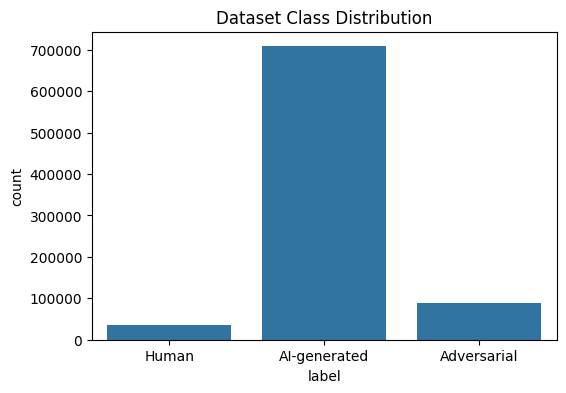

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 4))
sns.countplot(x=data["label"])
plt.xticks(ticks=[0, 1, 2], labels=["Human", "AI-generated", "Adversarial"])
plt.title("Dataset Class Distribution")
plt.show()


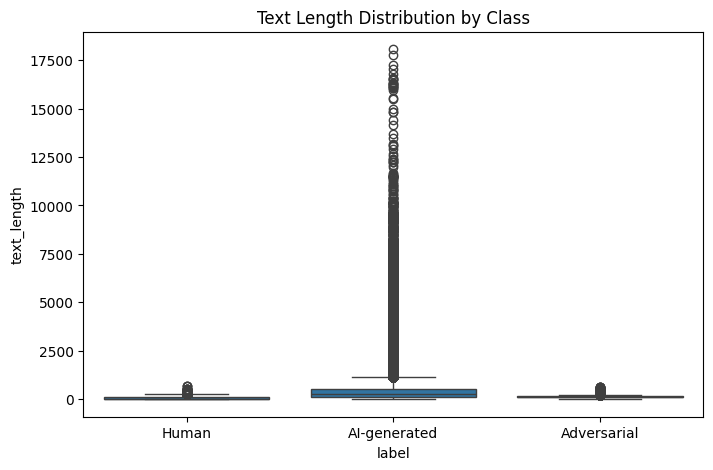

In [5]:
data["text_length"] = data["text"].apply(lambda x: len(x.split()))

plt.figure(figsize=(8, 5))
sns.boxplot(x=data["label"], y=data["text_length"])
plt.xticks(ticks=[0, 1, 2], labels=["Human", "AI-generated", "Adversarial"])
plt.title("Text Length Distribution by Class")
plt.show()


In [6]:
# prompt: now split the data into train and test

from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42) # 80% train, 20% test

print("Training data shape:", train_data.shape)
print("Testing data shape:", test_data.shape)


Training data shape: (666046, 3)
Testing data shape: (166512, 3)


In [9]:
import torch
import torch.nn as nn
from transformers import BertModel

class AdversarialTextDetector(nn.Module):
    def __init__(self, hidden_dim=256, num_classes=3):
        super(AdversarialTextDetector, self).__init__()
        self.bert = BertModel.from_pretrained("bert-base-cased")
        self.lstm = nn.LSTM(input_size=768, hidden_size=hidden_dim, num_layers=1, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(hidden_dim * 2, num_classes)

    def forward(self, input_ids, attention_mask):
        with torch.no_grad():  # Freeze BERT for contrastive step or tune as needed
            outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)

        lstm_out, _ = self.lstm(outputs.last_hidden_state)
        pooled_output = lstm_out[:, -1, :]  # Take the last hidden state

        logits = self.classifier(self.dropout(pooled_output))
        return logits, pooled_output  # logits for classification, pooled_output for contrastive loss


In [10]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        # Euclidean distance
        distances = torch.norm(output1 - output2, p=2, dim=1)
        loss = (1 - label) * torch.pow(distances, 2) + label * torch.pow(torch.clamp(self.margin - distances, min=0.0), 2)
        return torch.mean(loss)


In [11]:
# prompt: consider the first 20,000 amount as the data. use that

# Assuming 'data' DataFrame is already loaded as in the provided code.

# Use the first 20,000 entries
data_subset = data.head(20000)

# Now use data_subset instead of data for the rest of your code.
# Example: Splitting into training and testing sets
train_data, test_data = train_test_split(data_subset, test_size=0.2, random_state=42)

# ... (rest of your code using train_data and test_data)


In [12]:
from transformers import BertTokenizer
from torch.utils.data import Dataset, DataLoader
import torch
import numpy as np

# Initialize tokenizer (faster alternative)
tokenizer = BertTokenizer.from_pretrained("bert-base-cased",
                                        do_lower_case=False,
                                        cache_dir='tokenizer_cache')

class StreamlinedTextDataset(Dataset):
    def __init__(self, texts, labels, max_length=128):
        self.texts = texts
        self.labels = labels
        self.max_length = max_length

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Tokenize on-the-fly without caching (better for Colab's memory)
        encoding = tokenizer(
            self.texts[idx],
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors="pt"
        )

        return {
            "input_ids": encoding["input_ids"].squeeze(0),  # Remove batch dim
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "label": torch.tensor(self.labels[idx])
        }

# Usage with optimizations
train_dataset = StreamlinedTextDataset(train_data["text"].tolist(), train_data["label"].tolist())
test_dataset = StreamlinedTextDataset(test_data["text"].tolist(), test_data["label"].tolist())

# Optimized DataLoader settings for Colab
train_loader = DataLoader(
    train_dataset,
    batch_size=8,  # Reduced from 16 for Colab
    shuffle=True,
    num_workers=0,  # Colab works better with 0 workers
    pin_memory=True if torch.cuda.is_available() else False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=8,
    num_workers=0,
    pin_memory=True if torch.cuda.is_available() else False
)

C:\Users\venka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\venka\OneDrive\Desktop\NLP project_166\tokenizer_cache\models--bert-base-cased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [ ]:
# prompt: complete the remaining code by creating a hybrid model for displaying the adversarial attack probability using BERT,LSTM and contrastive learning

import torch.optim as optim

# Hyperparameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 5  # Reduced for faster execution
learning_rate = 2e-5
alpha = 0.5  # Weight for contrastive loss


model = AdversarialTextDetector().to(device)
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
criterion_cls = nn.CrossEntropyLoss()
criterion_cont = ContrastiveLoss()

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        logits, pooled_output = model(input_ids, attention_mask)

        # Contrastive loss (example: comparing human and AI generated texts within a batch)
        # Adapt this based on your specific contrastive learning strategy
        # For instance, you could compare samples of the same and different classes
        # within a batch, or apply other contrastive learning methods
        human_indices = (labels == 0).nonzero(as_tuple=False).squeeze()
        ai_indices = (labels == 1).nonzero(as_tuple=False).squeeze()
        if human_indices.numel() > 0 and ai_indices.numel() > 0: # if both classes are present in batch
          human_embeddings = pooled_output[human_indices]
          ai_embeddings = pooled_output[ai_indices]
          # Ensure both tensors have at least 2 dimensions
          if human_embeddings.dim() == 1:
              human_embeddings = human_embeddings.unsqueeze(0)
          if ai_embeddings.dim() == 1:
              ai_embeddings = ai_embeddings.unsqueeze(0)

          contrastive_labels = torch.zeros(min(human_embeddings.shape[0], ai_embeddings.shape[0]), dtype=torch.long, device=device) # 0 means similar (negative class)
          cont_loss = criterion_cont(human_embeddings[:contrastive_labels.shape[0]], ai_embeddings[:contrastive_labels.shape[0]], contrastive_labels)
        else:
          cont_loss = 0

        classification_loss = criterion_cls(logits, labels)
        loss = classification_loss + alpha * cont_loss  # Combined loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {total_loss / len(train_loader)}")


# Evaluation (example)
def evaluate_model(model, data_loader):
    model.eval()
    correct_predictions = 0
    total_samples = 0
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            logits, _ = model(input_ids, attention_mask)
            predicted_labels = torch.argmax(logits, dim=1)
            correct_predictions += (predicted_labels == labels).sum().item()
            total_samples += labels.size(0)
    accuracy = correct_predictions / total_samples
    return accuracy

test_accuracy = evaluate_model(model, test_loader)
print(f"Test Accuracy: {test_accuracy}")


C:\Users\venka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\venka\.cache\huggingface\hub\models--bert-base-cased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this r

In [ ]:
# prompt: predict using this model. and display the adversarial attack probability

import torch

# Assuming 'model', 'tokenizer', 'device', and 'test_loader' are defined as in the previous code.

def predict_and_adversarial_probability(model, tokenizer, device, text):
    model.eval()
    encoding = tokenizer(
        text,
        truncation=True,
        padding='max_length',
        max_length=128,  # Same max_length used during training
        return_tensors="pt"
    ).to(device)

    with torch.no_grad():
        logits, _ = model(encoding["input_ids"], encoding["attention_mask"])
        probabilities = torch.softmax(logits, dim=1)
        predicted_class = torch.argmax(probabilities, dim=1).item()

    # Adversarial probability (probability of the text being adversarial - class 2)
    adversarial_probability = probabilities[0, 2].item()

    return predicted_class, adversarial_probability

# Example usage
example_text = "This is a test sentence."
predicted_class, adversarial_prob = predict_and_adversarial_probability(model, tokenizer, device, example_text)

print(f"Predicted Class: {predicted_class}")
print(f"Adversarial Probability: {adversarial_prob}")


# Example usage with test data
for i in range(5):  # Test on a few samples from test_data
    example_text = test_data["text"].iloc[i]
    true_label = test_data["label"].iloc[i]
    predicted_class, adversarial_prob = predict_and_adversarial_probability(model, tokenizer, device, example_text)

    print(f"Text: {example_text[:50]}...")
    print(f"True Label: {true_label}")
    print(f"Predicted Class: {predicted_class}")
    print(f"Adversarial Probability: {adversarial_prob}")
    print("-" * 20)


Predicted Class: 1
Adversarial Probability: 0.13217976689338684
Text: Serena Williams will have to wait a little longer ...
True Label: 1
Predicted Class: 1
Adversarial Probability: 0.07861872762441635
--------------------
Text: As a pupil at Fettes College, Harry Letts enjoys c...
True Label: 1
Predicted Class: 1
Adversarial Probability: 0.06387870758771896
--------------------
Text: KUALA LUMPUR: International Trade and Industry Min...
True Label: 1
Predicted Class: 1
Adversarial Probability: 0.06570947170257568
--------------------
Text: In the tree a knot is either the base of a side br...
True Label: 2
Predicted Class: 1
Adversarial Probability: 0.2442806512117386
--------------------
Text: A Sugar Land mom's photo of a driver ignoring scho...
True Label: 1
Predicted Class: 1
Adversarial Probability: 0.06090550497174263
--------------------


In [ ]:
torch.save(model.state_dict(), "model.pth")